<a href="https://colab.research.google.com/github/Ropoga19/Imagenes1/blob/main/Laboratorio__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio No. 2**

**Metodos de regularización aplicado clasificadores de imágenes.**

Integrantes:

Paula Andrea Capera Tobar Código: 2201836

Ricardo Gutierrez Quintero Código: 2201063

Robert Portocarrero Gamboa Código: 2190702

**Paso 1.**
<font color='red'>Cargando librerias básicas y el dataset cifar10.</font>


In [2]:
import numpy as np
from numpy import expand_dims
import cv2
import tensorflow as tf
import tensorflow.keras.layers as LK 
import tensorflow.keras.models as MK
from keras.optimizers import SGD
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array

import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
import PIL, requests

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test,y_test)= cifar10.load_data() 

170500096/170498071 [==============================] - 8s 0us/step


**Paso 2.** <font color='red'>Normalizacion y reshape</font>


In [3]:

x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
x_train, x_test = (x_train-x_train.min())/(x_train.max()-x_train.min()), (x_test-x_test.min())/(x_test.max()-x_test.min()) #Normalizando


**Paso 3.** <font color='red'> Creación de la ConvNet</font>

Basados en la VGG de Simonyan y Zisserman. Luego de haber entrenado 3 modelos de redes neuronales diferentes entre si por la cantidad de bloques basicos que se fueron agregando secuencialmente,  se obtuvieron los siguientes resultados de accuracy y loss sobre el dataset de test.

<font color='red'>CNN con un solo bloque:</font><font color='blue'> ACC: 0.66</font> <font color='green'> LOSS: 2.194</font>

<font color='red'>CNN con un 2 bloques:</font><font color='blue'> 0.70</font> <font color='green'> LOSS: 2.664</font>

<font color='red'>CNN con un 3 bloques:</font><font color='blue'> 0.716</font> <font color='green'> LOSS: 2.1</font>

**Cabe anotar que dado el caracter probabilistico del clasificador los resultados pueden variar razonablemente, cada vez que el modelo sea entrenado nuevamente**

# ***EJERCICIO 1***

## ***MODELO BASE + DROPOOUT***

In [7]:
from keras.optimizers import SGD
tf.keras.backend.clear_session()

inputs = LK.Input(shape=(32,32,3)) 

conv1 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(inputs) 
conv2 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(conv1) 
pool1 = LK.MaxPool2D((2,2),(2,2))(conv2)
drop1= LK.Dropout(0.4)(pool1)

conv3 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(drop1) 
conv4 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(conv3) 
pool2 = LK.MaxPool2D((2,2),(2,2))(conv4) 
drop2= LK.Dropout(0.25)(pool2)

conv5 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(drop2) 
conv6 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(conv5) 
pool3 = LK.MaxPool2D((2,2),(2,2))(conv6) 
drop3= LK.Dropout(0.15)(pool3)

flat =  LK.Flatten()(drop3) 
FC3 = LK.Dense(128,activation='relu', kernel_initializer='he_normal')(flat)
outputs = LK.Dense(10,activation='softmax')(FC3) 

modelo_DP = MK.Model(inputs,outputs) #Modelo base + dropout
modelo_DP.summary()
optimo = SGD(lr=0.001, momentum=0.9)
modelo_DP.compile(optimizer=optimo, loss='sparse_categorical_crossentropy',metrics=['accuracy'] )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

In [ ]:
tf.keras.backend.clear_session()
history = modelo_DP.fit(x_train,y_train, epochs=100, batch_size=64,validation_data=(x_test, y_test), verbose=1)
loss,acc= modelo_DP.evaluate(x_test,y_test,verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss,acc) )

#GRÁFICA DE ACCURACY Y LOSS

from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title('Loss vs. Epoch')
ax2.set_title('Accuracy vs. Epoch')

ax1.plot(history.history['loss'], color='green', label='Train Loss')
ax1.plot(history.history['val_loss'], color='blue', label='Val loss')

ax2.plot(history.history['accuracy'], color='green', label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], color='blue', label='Val Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.show()

In [8]:
# SALVANDO EL MÓDELO
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
modelo_DP.save('Modelo_DP.h5')

## ***MODELO BASE + WEIGHT DECAY***

In [ ]:
#Weight decay
from keras.optimizers import SGD
from keras.regularizers import l2

tf.keras.backend.clear_session()

inputs = LK.Input(shape=(32,32,3)) 
conv1 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu', kernel_regularizer=l2(0.01))(inputs) 
conv2 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu', kernel_regularizer=l2(0.01))(conv1) 
pool1 = LK.MaxPool2D((2,2),(2,2))(conv2)

conv3 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu', kernel_regularizer=l2(0.01))(pool1) 
conv4 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu', kernel_regularizer=l2(0.01))(conv3)
pool2 = LK.MaxPool2D((2,2),(2,2))(conv4) 

conv5 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu', kernel_regularizer=l2(0.01))(pool2) 
conv6 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu', kernel_regularizer=l2(0.01))(conv5) 
pool3 = LK.MaxPool2D((2,2),(2,2))(conv6) 


flat = LK.Flatten()(pool3) 
FC3  = LK.Dense(128,activation='relu', kernel_initializer='he_normal')(flat)
outputs = LK.Dense(10,activation='softmax')(FC3) 

model_WD = MK.Model(inputs,outputs) 
model_WD.summary()
optimo = SGD(lr=0.001, momentum=0.9)
model_WD.compile(optimizer=optimo, loss='sparse_categorical_crossentropy',metrics=['accuracy'] )

In [ ]:
tf.keras.backend.clear_session()
history = model_WD.fit(x_train,y_train, epochs=100, batch_size=64,validation_data=(x_test, y_test), verbose=1)
loss,acc= model_WD.evaluate(x_test,y_test,verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss,acc) )

#GRÁFICA DE ACCURACY Y LOSS

from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title('Loss vs. Epoch')
ax2.set_title('Accuracy vs. Epoch')

ax1.plot(history.history['loss'], color='green', label='Train Loss')
ax1.plot(history.history['val_loss'], color='blue', label='Val loss')

ax2.plot(history.history['accuracy'], color='green', label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], color='blue', label='Val Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.show()

In [ ]:
# SALVANDO EL MÓDELO
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
model_WD.save('Modelo_WC.h5')

## ***MODELO BASE + DATA AUGMENTATION***

In [ ]:
from keras.optimizers import SGD
tf.keras.backend.clear_session()

inputs = LK.Input(shape=(32,32,3)) 

conv1 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(inputs) 
conv2 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(conv1) 
pool1 = LK.MaxPool2D((2,2),(2,2))(conv2)

conv3 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(pool1) 
conv4 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(conv3) 
pool2 = LK.MaxPool2D((2,2),(2,2))(conv4) 

conv5 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(pool2) 
conv6 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(conv5) 
pool3 = LK.MaxPool2D((2,2),(2,2))(conv6) 

flat =  LK.Flatten()(pool3) 
FC3 = LK.Dense(128,activation='relu', kernel_initializer='he_normal')(flat)
outputs = LK.Dense(10,activation='softmax')(FC3) 

modelo_DA = MK.Model(inputs,outputs) #Modelo base + data aughmentation
modelo_DA.summary()
optimo = SGD(lr=0.001, momentum=0.9)
modelo_DA.compile(optimizer=optimo, loss='sparse_categorical_crossentropy',metrics=['accuracy'] )

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(rotation_range= 15,
                            width_shift_range = 0.1,
                            height_shift_range= 0.1,
                            horizontal_flip=True,
                            vertical_flip= False,
                            )

datagen.fit(x_train)
iterador = datagen.flow(x_train, y_train, batch_size=64)
Paso_muestras = int(np.ceil(x_train.shape[0]/64))

history = modelo_DA.fit(x_train,y_train, epochs=50, batch_size=64,validation_data=(x_test, y_test), verbose=1)
loss,acc= modelo_DA.evaluate(x_test,y_test,verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss,acc) )

#GRÁFICA DE ACCURACY Y LOSS

from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title('Loss vs. Epoch')
ax2.set_title('Accuracy vs. Epoch')

ax1.plot(history.history['loss'], color='green', label='Train Loss')
ax1.plot(history.history['val_loss'], color='blue', label='Val loss')

ax2.plot(history.history['accuracy'], color='green', label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], color='blue', label='Val Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.show()

In [ ]:
# SALVANDO EL MÓDELO
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
modelo_DA.save('Modelo_DA.h5')

# **MODELO DATA AUGMENTATION CON DROPOUT**

Epoch 1/50
782/782 [==============================] - 6s 8ms/step - loss: 2.0022 - accuracy: 0.2641 - val_loss: 1.7393 - val_accuracy: 0.3758
Epoch 2/50
782/782 [==============================] - 6s 7ms/step - loss: 1.6566 - accuracy: 0.3948 - val_loss: 1.5497 - val_accuracy: 0.4400
Epoch 3/50
782/782 [==============================] - 6s 7ms/step - loss: 1.5003 - accuracy: 0.4514 - val_loss: 1.4869 - val_accuracy: 0.4652
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 1.3954 - accuracy: 0.4917 - val_loss: 1.3117 - val_accuracy: 0.5281
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 1.3237 - accuracy: 0.5212 - val_loss: 1.2511 - val_accuracy: 0.5497
Epoch 6/50
782/782 [==============================] - 6s 7ms/step - loss: 1.2594 - accuracy: 0.5467 - val_loss: 1.2127 - val_accuracy: 0.5649
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 1.2045 - accuracy: 0.5687 - val_loss: 1.1316 - val_accuracy: 0.6029
Epoch 

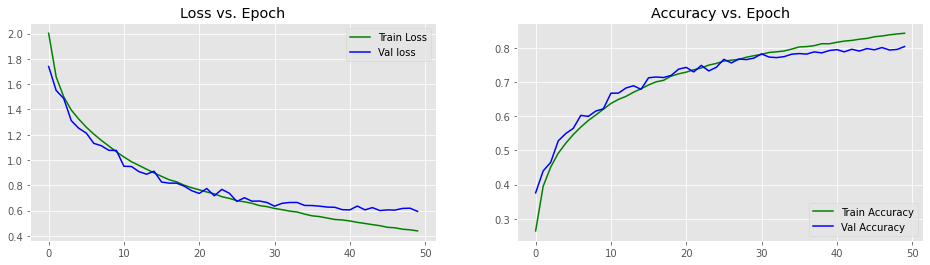

In [9]:
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.optimizers import SGD
from keras.models import load_model
from numpy import expand_dims
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

modelo = load_model('/content/Modelo_DP.h5')  # se carga el modelo previamente guardado

datagen = ImageDataGenerator(rotation_range= 15,
                            width_shift_range = 0.1,
                            height_shift_range= 0.1,
                            horizontal_flip=True,
                            vertical_flip= False,
                            )

datagen.fit(x_train)
iterador = datagen.flow(x_train, y_train, batch_size=64)
Paso_muestras = int(np.ceil(x_train.shape[0]/64))

history = modelo_DP.fit(x_train,y_train, epochs=50, batch_size=64,validation_data=(x_test, y_test), verbose=1)
loss,acc= modelo_DP.evaluate(x_test,y_test,verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss,acc) )

#GRÁFICA DE ACCURACY Y LOSS

from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title('Loss vs. Epoch')
ax2.set_title('Accuracy vs. Epoch')

ax1.plot(history.history['loss'], color='green', label='Train Loss')
ax1.plot(history.history['val_loss'], color='blue', label='Val loss')

ax2.plot(history.history['accuracy'], color='green', label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], color='blue', label='Val Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.show()

## **Salvando Modelo **

In [10]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
modelo_DP.save('ModeloDA-DP.h5')


In [ ]:
!rm -rf https://github.com/Ropoga19/ImagenesRNA.git

# **PREDICCIÓN  DE UNA IMAGEN**

fatal: destination path 'Imagenes1' already exists and is not an empty directory.


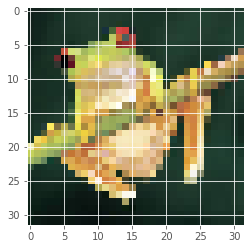

Rana


In [14]:
from keras_preprocessing.image import img_to_array
from numpy import expand_dims
import matplotlib.pyplot as plt
from keras_preprocessing.image import load_img
import base64
model= load_model('/content/ModeloDA-DP.h5')

!git clone https://github.com/Ropoga19/Imagenes1.git

img = load_img('Imagenes1/frog1.jpg', target_size=(32,32))

plt.imshow(img)
plt.show()
img = img_to_array(img)
img = img.reshape(1,32,32,3)
img = img.astype('float32')
img = img/255.0

etiquetas = ["Avión", "Automovil", "Pajaro", "Gato", "Siervo", "Perro", "Rana", "Caballo", "Barco", "Camion"]
resultado = model.predict(img)
print( etiquetas[(np.argmax(resultado,axis=1))[0]])


# ***PREDICCIÓN de un SET de IMAGENES***

fatal: destination path 'Imagenes1' already exists and is not an empty directory.


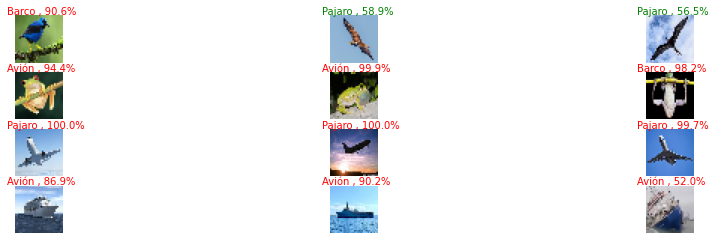

In [13]:
import glob
from matplotlib import pyplot as plt

model= load_model('/content/ModeloDA-DP.h5') #Cargar modelo
!git clone https://github.com/Ropoga19/Imagenes1.git # Carpeta con imagenes

ETIQUETA =["Avión", "Automovil", "Pajaro", "Gato", "Siervo", "Perro", "Rana", "Caballo", "Barco", "Camion"]
imagenes =['bird1.jpg','bird2.jpg', 'bird3.jpg', 'frog1.jpg', 'frog2.jpg', 'frog3.jpg', 'plane1.jpg', 'plane2.jpg', 'plane3.jpg', 'ship1.jpg','ship2.jpg','ship3.jpg' ]
categoria = ['Pajaro','Pajaro','Pajaro','Rana','Rana','Rana','Avión','Avión','Avión','Barco','Barco','Barco']

j= 0
largo = len(imagenes)

for i in imagenes:

  imgcon = 'Imagenes1/' + i
  img = load_img(imgcon, target_size=(32,32))
  img1 = img_to_array(img)
  img1 = img1.reshape(1,32,32,3)
  img1 = img1.astype('float32')
  img1 = img1/255.0
  
  prediccion = model.predict(img1)
  Nombre = categoria[(np.argmax(prediccion, axis=1))[0]]
  
  j = j + 1
  plt.subplot(4,3,j)
  plt.axis('off')
  plt.imshow(img)
  plt.text(-6, -1, Nombre + ' , ' + str(round(np.max(prediccion)*100,1))+ '%', 
           fontsize=10, color=("green" if categoria[j-1] == Nombre else "red"))        
plt.show()
  